In [1]:
# %% [code] {"id":"5OH-Bgo4NSK5_modified_imports"}
# Install necessary libraries if not already present (especially for Colab)
!pip install pymystem3 imbalanced-learn # or latest versions

# Import necessary libraries
import pandas as pd
import numpy as np
import re
import ast  # For safely evaluating string representations of lists
import os # For file paths

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem # For Lemmatization
# from sklearn.preprocessing import FunctionTransformer # For Trigger words (Optional)
# from scipy.sparse import hstack # For combining features (Optional)

# Modeling & Evaluation
from sklearn.model_selection import train_test_split # Ensure this is imported
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem
from sklearn.linear_model import LogisticRegression # Keep for comparison maybe, but will replace
from sklearn.svm import LinearSVC # <<<--- Add this import
from sklearn.metrics import (classification_report, accuracy_score, f1_score,
                             confusion_matrix, precision_recall_curve, hamming_loss)
from sklearn.preprocessing import MultiLabelBinarizer
from imblearn.over_sampling import SMOTE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
np.random.seed(42)

# --- Configuration ---
# Mount Google Drive (if your data is stored there)
USE_DRIVE = False # Set to False if data is local
BASE_DRIVE_PATH = "/content/drive/MyDrive/For Colab/" # Adjust this path as needed!

if USE_DRIVE:
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        DATA_PATH_TRAIN_N = os.path.join(BASE_DRIVE_PATH, "train.parquet")
        DATA_PATH_TRAIN_S = os.path.join(BASE_DRIVE_PATH, "synthetic_train_dataset.csv")
        DATA_PATH_TEST = os.path.join(BASE_DRIVE_PATH, "test.csv") # Path for final test file
        SUBMISSION_PATH = "/content/submission.csv" # Output path for submission
        print("Google Drive mounted.")
    except ModuleNotFoundError:
        print("Not running in Colab or Drive mounting failed. Assuming data is local.")
        USE_DRIVE = False # Fallback to local if drive fails
        # Define local paths if USE_DRIVE=False or mounting fails
        DATA_PATH_TRAIN_N = "train.parquet"
        DATA_PATH_TRAIN_S = "synthetic_train_dataset.csv"
        DATA_PATH_TEST = "/kaggle/input/unlp-2025-shared-task-classification-techniques/test.csv"
        SUBMISSION_PATH = "/kaggle/working/submission-tf-idf.csv"
else:
     # Define local paths if USE_DRIVE=False from the start
    DATA_PATH_TRAIN_N = "/kaggle/input/unlp-2025-shared-task-classification-techniques/train.parquet"
    DATA_PATH_TRAIN_S = "/kaggle/input/unlp-dataset/synthetic_train_dataset.csv"
    DATA_PATH_TEST = "/kaggle/input/unlp-2025-shared-task-classification-techniques/test.csv"
    SUBMISSION_PATH = "/kaggle/working/submission-tf-idf.csv"


print(f"Using Native Train data path: {DATA_PATH_TRAIN_N}")
print(f"Using Synthetic Train data path: {DATA_PATH_TRAIN_S}")
print(f"Using Test data path: {DATA_PATH_TEST}")
print(f"Using Submission output path: {SUBMISSION_PATH}")

# Initialize Lemmatizer (Mystem) - outside function for efficiency
try:
    lemmatizer = Mystem()
    print("Mystem lemmatizer initialized.")
except Exception as e:
    print(f"Could not initialize Mystem: {e}. Lemmatization will be skipped.")
    lemmatizer = None

Using Native Train data path: /kaggle/input/unlp-2025-shared-task-classification-techniques/train.parquet
Using Synthetic Train data path: /kaggle/input/unlp-dataset/synthetic_train_dataset.csv
Using Test data path: /kaggle/input/unlp-2025-shared-task-classification-techniques/test.csv
Using Submission output path: /kaggle/working/submission-tf-idf.csv


Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


Mystem lemmatizer initialized.


In [2]:
# %% [code] {"id":"xmlvyMbNOQpw","outputId":"6f4a8783-1e1f-4a52-fa73-4083915acddd"}
# Load the dataset
try:
    df = pd.read_parquet(DATA_PATH_TRAIN_N)
    print(f"Loaded {DATA_PATH_TRAIN_N} successfully.")
    # try:
    #     df_s = pd.read_csv(DATA_PATH_TRAIN_S)
    #     df_s['techniques'] = df_s['techniques'].apply(
    #         lambda x: [x] if isinstance(x, str) else x
    #     )
    #     print(f"Loaded {DATA_PATH_TRAIN_S} successfully.")
    #     df = pd.concat([df_n, df_s], ignore_index=True) # Use ignore_index for clean concat
    #     print("Concatenated native and synthetic datasets.")
    # except FileNotFoundError:
    #     print(f"Warning: Synthetic data file not found at {DATA_PATH_TRAIN_S}. Using only native data.")
    #     df = df_n
    # except Exception as e_s:
    #     print(f"Warning: Error loading synthetic data from {DATA_PATH_TRAIN_S}: {e_s}. Using only native data.")
    #     df = df_n

except FileNotFoundError:
    print(f"Error: Native data file not found at {DATA_PATH_TRAIN_N}")
    print("Please ensure the file exists and the path is correct.")
    raise SystemExit("Stopping notebook execution - Native training data required.")
except Exception as e_n:
    print(f"Error loading native data from {DATA_PATH_TRAIN_N}: {e_n}")
    raise SystemExit("Stopping notebook execution.")


# Display basic info and first few rows
print("\nDataset Info:")
df.info()
print("\nFirst 5 rows:")
print(df.head())
print(f"\nDataset shape: {df.shape}")

# --- Revised Handling of Missing Values ---
# 1. Drop rows ONLY if 'content' is missing, as text is essential.
print("\nMissing values before handling:")
print(df.isnull().sum())
df.dropna(subset=['content'], inplace=True)
print(f"\nShape after dropping rows with missing 'content': {df.shape}")

# 2. Fill missing 'techniques' with an empty string representation '[]'
df['techniques'] = df['techniques'].fillna('[]').astype(str)

# Check again (should show 0 nulls for content and techniques)
print("\nMissing values after handling:")
print(df.isnull().sum())

print(f"\nDataset shape after handling NaNs: {df.shape}")

Loaded /kaggle/input/unlp-2025-shared-task-classification-techniques/train.parquet successfully.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3822 entries, 0 to 3821
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             3822 non-null   object
 1   content        3822 non-null   object
 2   lang           3822 non-null   object
 3   manipulative   3822 non-null   bool  
 4   techniques     2589 non-null   object
 5   trigger_words  2589 non-null   object
dtypes: bool(1), object(5)
memory usage: 153.2+ KB

First 5 rows:
                                     id  \
0  0bb0c7fa-101b-4583-a5f9-9d503339141c   
1  7159f802-6f99-4e9d-97bd-6f565a4a0fae   
2  e6a427f1-211f-405f-bd8b-70798458d656   
3  1647a352-4cd3-40f6-bfa1-d87d42e34eea   
4  9c01de00-841f-4b50-9407-104e9ffb03bf   

                                             content lang  manipulative  \
0  Новий огляд мапи DeepState від росі

Cell 3: Parse Techniques

In [3]:
# %% [markdown] {"id":"bKudQfE6QokL"}
# Cell 3: Parse Techniques

# %% [code] {"id":"thv6SSpAOX0h","outputId":"a4a4a6da-9b73-4c96-ad30-7b34d51592c3"}
# --- Define the Canonical List of Techniques ---
# These are the ONLY techniques we want to classify
CANONICAL_TECHNIQUES = sorted([
    'straw_man', 'appeal_to_fear', 'fud', 'bandwagon', 'whataboutism',
    'loaded_language', 'glittering_generalities', 'euphoria',
    'cherry_picking', 'cliche'
])
print(f"Target Techniques ({len(CANONICAL_TECHNIQUES)}):")
print(CANONICAL_TECHNIQUES)
# --------------------------------------------

# Function to safely parse the 'techniques' string, filter by canonical list,
# AND handle concatenated techniques.
def parse_filter_split_techniques(tech_string):
    # 1. Handle None or obvious empty representations first
    if tech_string is None or not isinstance(tech_string, str) or tech_string.strip().lower() in ['', '[]', '{}', '()', 'nan']:
        return []

    # Use a set to automatically handle duplicates
    found_techniques = set()
    processed_string = tech_string.strip().lower() # Work with lowercase, stripped string

    # 2. Try standard parsing (ast.literal_eval) for clean list formats
    try:
        evaluated = ast.literal_eval(processed_string)
        if isinstance(evaluated, list):
            for item in evaluated:
                item_clean = str(item).strip()
                if item_clean in CANONICAL_TECHNIQUES:
                    found_techniques.add(item_clean)
                # --- Substring Check WITHIN list items ---
                # Check if this item itself is a concatenation
                elif item_clean: # Avoid check on empty strings from list
                        for canonical_tech in CANONICAL_TECHNIQUES:
                            if canonical_tech in item_clean:
                                found_techniques.add(canonical_tech)
            # If ast worked, we assume it covers the structure, return results
            return sorted(list(found_techniques))

    except (ValueError, SyntaxError):
        # ast failed, proceed to regex and substring checks on the original string
        pass

    # 3. Try regex for potentially separated words (if ast failed)
    # This helps with formats like "'tech1' 'tech2'" or just single words
    techniques_found_regex = re.findall(r"\'(.*?)\'|\"(.*?)\"|(\b\w+(?:[-']\w+)*\b)", processed_string)
    flat_list = [item.strip() for sublist in techniques_found_regex for item in sublist if item and item.strip()]

    # If regex found multiple distinct items OR the only item found matches a canonical technique, add them
    if len(flat_list) > 1 or (len(flat_list) == 1 and flat_list[0] in CANONICAL_TECHNIQUES):
        for tech in flat_list:
            if tech in CANONICAL_TECHNIQUES:
                found_techniques.add(tech)

    # 4. Perform Substring Check on the original (cleaned) string
    # This is the main part to catch concatenations like 'loaded_languagewhataboutism'
    # It runs even if regex found something, to be safe.
    # We clean potential list artifacts just in case
    cleaned_for_substring = processed_string.replace("'", "").replace('"', '').replace('[', '').replace(']', '').replace(',', ' ').strip()
    # Remove extra spaces that might result from replacement
    cleaned_for_substring = re.sub(r'\s+', ' ', cleaned_for_substring).strip()

    if cleaned_for_substring: # Avoid checking empty strings
        for canonical_tech in CANONICAL_TECHNIQUES:
            # Check if the canonical tech exists as a whole word or part of the string
            # Simple 'in' check is more robust for direct concatenation
            if canonical_tech in cleaned_for_substring:
                found_techniques.add(canonical_tech)

    # 5. Return the unique, filtered, sorted list
    return sorted(list(found_techniques))

# --- Apply the NEW parsing function ---
df['parsed_techniques_filtered'] = df['techniques'].apply(parse_filter_split_techniques)

# --- The rest of Cell 3 remains the same ---

# Verify the parsing and filtering - check examples, especially concatenated ones
print("\nSample of original, parsed & filtered techniques:")
print(df[['techniques', 'parsed_techniques_filtered']].head(10))
print(df[['techniques', 'parsed_techniques_filtered']].tail(10)) # Check end as well

# -- MultiLabelBinarizer --
# Initialize explicitly with the canonical classes
mlb = MultiLabelBinarizer(classes=CANONICAL_TECHNIQUES)

# Fit and transform using the filtered techniques column
y = mlb.fit_transform(df['parsed_techniques_filtered'])

# Get the names of the technique columns (will match CANONICAL_TECHNIQUES now)
technique_columns = mlb.classes_ # Should be the same as CANONICAL_TECHNIQUES now
print(f"\nShape of binary label matrix y: {y.shape}")
print(f"Columns in y correspond to: {technique_columns}")

# Create a DataFrame with the binary labels
y_df = pd.DataFrame(y, columns=technique_columns, index=df.index)

# Concatenate with the original dataframe (optional, but useful for inspection)
df_processed = pd.concat([df, y_df], axis=1)

print("\nDataFrame with binary technique columns (first 5 rows):")
print(df_processed[['content'] + list(technique_columns)].head())

# Check class distribution for each technique
print("\nClass Distribution (Number of positive samples per technique):")
print(y_df.sum().sort_values(ascending=False))

# Check how many samples have NO techniques (all zeros in y_df)
no_technique_count = (y_df.sum(axis=1) == 0).sum()
print(f"\nNumber of samples with NO techniques identified (among the {len(technique_columns)} target ones): {no_technique_count}")

Target Techniques (10):
['appeal_to_fear', 'bandwagon', 'cherry_picking', 'cliche', 'euphoria', 'fud', 'glittering_generalities', 'loaded_language', 'straw_man', 'whataboutism']

Sample of original, parsed & filtered techniques:
                                          techniques  \
0                     ['euphoria' 'loaded_language']   
1               ['loaded_language' 'cherry_picking']   
2                     ['loaded_language' 'euphoria']   
3                                                 []   
4                                ['loaded_language']   
5                                ['loaded_language']   
6                                                 []   
7  ['loaded_language' 'glittering_generalities' '...   
8                        ['cherry_picking' 'cliche']   
9  ['loaded_language' 'cherry_picking' 'appeal_to...   

                          parsed_techniques_filtered  
0                        [euphoria, loaded_language]  
1                  [cherry_picking, loaded_l

In [4]:
# %% [code] {"id":"l9u-hPBZPJAM_modified_clean_triggers_numpy"}
import numpy as np # Ensure numpy is imported
import pandas as pd # Ensure pandas is imported

# Basic text cleaning function WITH LEMMATIZATION (remains the same)
def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s\']', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    if lemmatizer:
        try:
            lemmas = lemmatizer.lemmatize(text)
            text = "".join(lemmas).strip()
            text = re.sub(r'\s+', ' ', text).strip()
        except Exception as e:
            # print(f"Warning: Lemmatization failed for text snippet: '{text[:50]}...' Error: {e}")
            pass
    return text


# --- Apply Cleaning and Feature Engineering ---

# 1. Apply cleaning to the 'content' column
print("\nApplying text cleaning and lemmatization...")
df_processed['cleaned_content'] = df_processed['content'].apply(clean_text)
print("Text cleaning and lemmatization complete.")

print("\nSample of original vs cleaned/lemmatized content:")
print(df_processed[['content', 'cleaned_content']].head())


Applying text cleaning and lemmatization...
Text cleaning and lemmatization complete.

Sample of original vs cleaned/lemmatized content:
                                             content  \
0  Новий огляд мапи DeepState від російського вій...   
1  Недавно 95 квартал жёстко поглумился над русск...   
2  🤩\nТим часом йде евакуація Бєлгородського авто...   
3  В Україні найближчим часом мають намір посилит...   
4  Расчёты 122-мм САУ 2С1 "Гвоздика" 132-й бригад...   

                                     cleaned_content  
0  новий огляд мапи deepstate від росийський вийс...  
1  недавно 95 квартал жестко поглумиться над русс...  
2  тим час йде евакуация бєлгородського автовокза...  
3  в україні найближчим час мають намир посилити ...  
4  расчет 122 мм сау 2с1 гвоздик 132 й бригада 1 ...  


In [5]:

# --- Helper function to extract phrases for a single row ---
# Returns a list of phrases, or None if no valid phrases can be extracted.
def extract_trigger_phrases_for_row(row):
    """Extracts text phrases based on spans in 'trigger_words' for a single row."""
    # Make sure 'content' is treated as a string
    content = str(row['content']) if pd.notna(row['content']) else ""
    trigger_obj = row['trigger_words']

    spans_to_process = trigger_obj

    # Check if spans were actually found or if array/list was empty/invalid
    if not isinstance(spans_to_process, np.ndarray) and not spans_to_process: # Handles empty list
         if isinstance(trigger_obj, np.ndarray) and trigger_obj.size == 0: # Handles empty numpy array
              return None
         # Optionally warn about unexpected formats, but might be too verbose
         return None # No valid spans found or unexpected format
    # Extract phrases using spans
    extracted_phrases = []
    content_len = len(content)
    for span in spans_to_process:
        try:
            start = int(span[0])
            end = int(span[1])
            # Validate indices: 0 <= start < end <= content_length
            if 0 <= start < content_len and start < end and end <= content_len:
                phrase = content[start:end].strip()

                if phrase:
                    # 2. Clean the extracted phrase using the main cleaning function
                    cleaned_phrase = clean_text(phrase)
                    # 3. Add the cleaned phrase ONLY if it's not empty after cleaning
                    if cleaned_phrase:
                        extracted_phrases.append(cleaned_phrase)
        except (ValueError, TypeError, IndexError):
            continue # Skip invalid spans

    return extracted_phrases if extracted_phrases else None # Return list of phrases or None



print(df_processed.columns)


# 2. Initialize the global dictionary using defaultdict
# Use dictionary comprehension to initialize with empty lists
technique_triggers_global = {tech: [] for tech in CANONICAL_TECHNIQUES}
print(f"Initialized 'technique_triggers_global' with {len(technique_triggers_global)} techniques (all starting with empty lists).")

# 3. Process trigger words and aggregate into the global dictionary
if 'trigger_words' in df_processed.columns and 'parsed_techniques_filtered' in df_processed.columns:
    print("\nExtracting trigger phrases and aggregating into global dictionary 'technique_triggers_global'...")

    processed_rows = 0
    phrases_aggregated = 0
    # Iterate through the DataFrame rows
    for index, row in df_processed.iterrows():
        # Ensure 'parsed_techniques_filtered' is a list
        techniques_list = row['parsed_techniques_filtered'] if isinstance(row['parsed_techniques_filtered'], list) else []

        # Skip rows with no techniques identified
        if not techniques_list:
            continue

        # Extract phrases for the current row
        extracted_phrases = extract_trigger_phrases_for_row(row)

        # If phrases were extracted, add them to the global dict for each relevant technique
        if extracted_phrases: # Check if the list is not None and not empty
            for tech in techniques_list:
                # defaultdict automatically creates the list for a new key
                technique_triggers_global[tech].extend(extracted_phrases)
                phrases_aggregated += len(extracted_phrases) # Count total phrases added
            processed_rows += 1

    print(f"Finished aggregation. Processed {processed_rows} rows with techniques and triggers.")
    print(f"Aggregated a total of {phrases_aggregated} phrase instances across all techniques.")

    # Display info about the created dictionary
    if technique_triggers_global:
        print(f"\nTechniques found in dictionary: {len(technique_triggers_global)}")
        print("Number of trigger phrases aggregated per technique (top 10):")
        # Calculate counts and sort
        phrase_counts = {tech: len(phrases) for tech, phrases in technique_triggers_global.items()}
        sorted_counts = sorted(phrase_counts.items(), key=lambda item: item[1], reverse=True)
        for tech, count in sorted_counts[:10]:
            print(f"- {tech}: {count}")

        # Example: Print a few phrases for one technique
        # sample_tech = sorted_counts[0][0] if sorted_counts else None # Get tech with most phrases
        # if sample_tech:
        #    print(f"\nSample phrases for '{sample_tech}' (first 5 unique):")
        #    unique_phrases = sorted(list(set(technique_triggers_global[sample_tech])))
        #    print(unique_phrases[:5])
    else:
        print("The global dictionary 'technique_triggers_global' is empty.")


else:
    print("\nSkipping global technique-trigger phrase aggregation: 'trigger_words' or 'parsed_techniques_filtered' column not found.")
    # technique_triggers_global remains an empty defaultdict

Index(['id', 'content', 'lang', 'manipulative', 'techniques', 'trigger_words',
       'parsed_techniques_filtered', 'appeal_to_fear', 'bandwagon',
       'cherry_picking', 'cliche', 'euphoria', 'fud',
       'glittering_generalities', 'loaded_language', 'straw_man',
       'whataboutism', 'cleaned_content'],
      dtype='object')
Initialized 'technique_triggers_global' with 10 techniques (all starting with empty lists).

Extracting trigger phrases and aggregating into global dictionary 'technique_triggers_global'...
Finished aggregation. Processed 2577 rows with techniques and triggers.
Aggregated a total of 21617 phrase instances across all techniques.

Techniques found in dictionary: 10
Number of trigger phrases aggregated per technique (top 10):
- loaded_language: 7197
- cherry_picking: 2542
- cliche: 2350
- glittering_generalities: 2159
- fud: 1755
- euphoria: 1687
- appeal_to_fear: 1365
- bandwagon: 939
- whataboutism: 819
- straw_man: 804


In [6]:
# %% [code] {"id":"eaUdI_TwPacR_train_test_only"}
# Define features (X) and target labels (y_df created via MLB in Cell 2/3)
X = df_processed['cleaned_content']
# y_df holds the multi-label binary targets

# Split the data into training and testing sets (e.g., 80% train, 20% test)
# Reverting to only Train and Test sets
X_train, X_test, y_train_df, y_test_df = train_test_split(
    X,
    y_df,
    test_size=0.20, # 20% for the test set
    random_state=42
    # Stratification is complex for multi-label; not used here.
)

print(f"Training set shape: X={X_train.shape}, y={y_train_df.shape}")
# print(f"Validation set shape: X={X_val.shape}, y={y_val_df.shape}") # REMOVED
print(f"Test set shape: X={X_test.shape}, y={y_test_df.shape}")

# Verify the split percentages
total_len = len(X_train) + len(X_test)
print(f"\nTotal samples in split: {total_len} (should match original if test_size=0.2)")
print(f"Train %: {len(X_train)/(total_len):.2f}, Test %: {len(X_test)/(total_len):.2f}")

Training set shape: X=(3057,), y=(3057, 10)
Test set shape: X=(765,), y=(765, 10)

Total samples in split: 3822 (should match original if test_size=0.2)
Train %: 0.80, Test %: 0.20


In [7]:
# %% [code] {"id":"ldZU4pxwPi-a_tfidf_combine_no_val"}
import re
from scipy.sparse import hstack, csr_matrix
import numpy as np

# Initialize TF-IDF Vectorizer (same as before)
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    analyzer='char_wb',
    ngram_range=(3, 5),
    min_df=3,
    max_df=0.9
)
print("Initializing TF-IDF Vectorizer...")
print("Fitting TF-IDF on training data...")
tfidf_vectorizer.fit(X_train) # Fit only on X_train
print("Fit complete.")
print("Transforming datasets (TF-IDF)...")
X_train_tfidf = tfidf_vectorizer.transform(X_train)
# X_val_tfidf = tfidf_vectorizer.transform(X_val) # REMOVED
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print("TF-IDF transformation complete.")
print(f"Shape of TF-IDF matrices: Train={X_train_tfidf.shape}, Test={X_test_tfidf.shape}") # Removed Val shape

# --- Add Trigger Phrase Presence Features ---

print("\nAttempting to add Trigger Phrase Presence features...")
USE_TRIGGER_PRESENCE_FEATURES = False # Default flag

if 'technique_triggers_global' not in globals() or not isinstance(technique_triggers_global, dict):
    print("Warning: 'technique_triggers_global' dictionary not found or invalid. Skipping trigger presence features.")
else:
    print(f"Found 'technique_triggers_global' with {len(technique_triggers_global)} techniques.")
    trigger_patterns = {}
    # ...(logic to compile trigger_patterns - same as before)...
    for tech, phrases in technique_triggers_global.items():
        valid_phrases = [re.escape(p) for p in phrases if len(p) > 1]
        if valid_phrases:
            pattern = r'\b(' + '|'.join(valid_phrases) + r')\b'
            try: trigger_patterns[tech] = re.compile(pattern, flags=re.IGNORECASE)
            except Exception as e_re: print(f"Warning: Error compiling regex for '{tech}'. Skipping. Error: {e_re}")

    print(f"Compiled regex patterns for {len(trigger_patterns)} techniques.")

    def check_trigger_presence_regex(text, pattern): # Function remains the same
        if pattern and isinstance(text, str): return 1 if pattern.search(text) else 0
        return 0

    trigger_features_train = []
    # trigger_features_val = [] # REMOVED
    trigger_features_test = []
    feature_names = []

    if 'CANONICAL_TECHNIQUES' not in globals(): raise NameError("CANONICAL_TECHNIQUES list not found.")

    print("Generating trigger presence features for Train/Test sets...") # Removed Val
    for tech in CANONICAL_TECHNIQUES:
        pattern = trigger_patterns.get(tech)
        if pattern:
            feature_name = f'trigger_present_{tech}'
            feature_names.append(feature_name)
            trigger_features_train.append(X_train.apply(lambda text: check_trigger_presence_regex(text, pattern)))
            # trigger_features_val.append(X_val.apply(lambda text: check_trigger_presence_regex(text, pattern))) # REMOVED
            trigger_features_test.append(X_test.apply(lambda text: check_trigger_presence_regex(text, pattern)))

    if trigger_features_train:
        print(f"Created {len(feature_names)} trigger presence features.")
        trigger_array_train = np.array(trigger_features_train).T
        # trigger_array_val = np.array(trigger_features_val).T # REMOVED
        trigger_array_test = np.array(trigger_features_test).T

        trigger_sparse_train = csr_matrix(trigger_array_train)
        # trigger_sparse_val = csr_matrix(trigger_array_val) # REMOVED
        trigger_sparse_test = csr_matrix(trigger_array_test)

        print("Combining TF-IDF features with trigger presence features...")
        X_train_combined = hstack([X_train_tfidf, trigger_sparse_train], format='csr')
        # X_val_combined = hstack([X_val_tfidf, trigger_sparse_val], format='csr') # REMOVED
        X_test_combined = hstack([X_test_tfidf, trigger_sparse_test], format='csr')

        X_train_tfidf = X_train_combined
        # X_val_tfidf = X_val_combined # REMOVED - Ensure no reference later
        X_test_tfidf = X_test_combined

        print(f"Shape AFTER combining features: Train={X_train_tfidf.shape}, Test={X_test_tfidf.shape}") # Removed Val shape
        USE_TRIGGER_PRESENCE_FEATURES = True
    else:
        print("No trigger presence features were created. Using only TF-IDF.")
        USE_TRIGGER_PRESENCE_FEATURES = False
# --- End of Trigger Feature Addition ---

Initializing TF-IDF Vectorizer...
Fitting TF-IDF on training data...
Fit complete.
Transforming datasets (TF-IDF)...
TF-IDF transformation complete.
Shape of TF-IDF matrices: Train=(3057, 10000), Test=(765, 10000)

Attempting to add Trigger Phrase Presence features...
Found 'technique_triggers_global' with 10 techniques.
Compiled regex patterns for 10 techniques.
Generating trigger presence features for Train/Test sets...
Created 10 trigger presence features.
Combining TF-IDF features with trigger presence features...
Shape AFTER combining features: Train=(3057, 10010), Test=(765, 10010)



--- Processing: appeal_to_fear ---
Training data: 242 positive samples out of 3057
Applying SMOTE...
After SMOTE: 2815/5630
Initializing LinearSVC model...
Training LinearSVC model...
Training complete.
Evaluating on TEST set...
Test Accuracy: 0.8797
Test F1-Score (Positive Class): 0.2923
Test Classification Report:
                    precision    recall  f1-score   support

Not_appeal_to_fear       0.94      0.93      0.93       707
    appeal_to_fear       0.26      0.33      0.29        58

          accuracy                           0.88       765
         macro avg       0.60      0.63      0.61       765
      weighted avg       0.89      0.88      0.89       765

Test Confusion Matrix:
[[654  53]
 [ 39  19]]


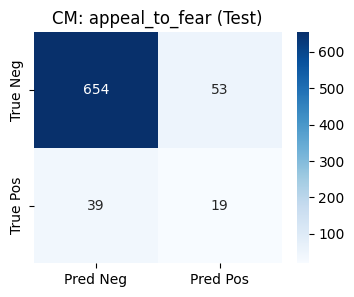


--- Processing: bandwagon ---
Training data: 122 positive samples out of 3057
Applying SMOTE...
After SMOTE: 2935/5870
Initializing LinearSVC model...
Training LinearSVC model...
Training complete.
Evaluating on TEST set...
Test Accuracy: 0.9359
Test F1-Score (Positive Class): 0.1404
Test Classification Report:
               precision    recall  f1-score   support

Not_bandwagon       0.96      0.98      0.97       730
    bandwagon       0.18      0.11      0.14        35

     accuracy                           0.94       765
    macro avg       0.57      0.54      0.55       765
 weighted avg       0.92      0.94      0.93       765

Test Confusion Matrix:
[[712  18]
 [ 31   4]]


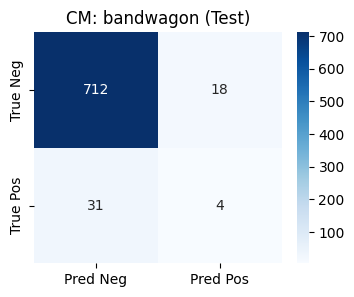


--- Processing: cherry_picking ---
Training data: 415 positive samples out of 3057
Applying SMOTE...
After SMOTE: 2642/5284
Initializing LinearSVC model...
Training LinearSVC model...
Training complete.
Evaluating on TEST set...
Test Accuracy: 0.8327
Test F1-Score (Positive Class): 0.4336
Test Classification Report:
                    precision    recall  f1-score   support

Not_cherry_picking       0.92      0.88      0.90       668
    cherry_picking       0.38      0.51      0.43        97

          accuracy                           0.83       765
         macro avg       0.65      0.69      0.67       765
      weighted avg       0.86      0.83      0.84       765

Test Confusion Matrix:
[[588  80]
 [ 48  49]]


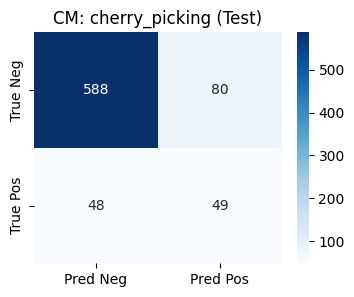


--- Processing: cliche ---
Training data: 370 positive samples out of 3057
Applying SMOTE...
After SMOTE: 2687/5374
Initializing LinearSVC model...
Training LinearSVC model...
Training complete.
Evaluating on TEST set...
Test Accuracy: 0.7882
Test F1-Score (Positive Class): 0.2286
Test Classification Report:
              precision    recall  f1-score   support

  Not_cliche       0.89      0.86      0.88       672
      cliche       0.21      0.26      0.23        93

    accuracy                           0.79       765
   macro avg       0.55      0.56      0.55       765
weighted avg       0.81      0.79      0.80       765

Test Confusion Matrix:
[[579  93]
 [ 69  24]]


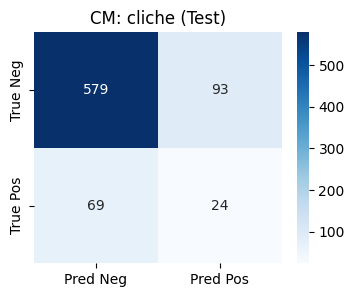


--- Processing: euphoria ---
Training data: 385 positive samples out of 3057
Applying SMOTE...
After SMOTE: 2672/5344
Initializing LinearSVC model...
Training LinearSVC model...
Training complete.
Evaluating on TEST set...
Test Accuracy: 0.9085
Test F1-Score (Positive Class): 0.6067
Test Classification Report:
              precision    recall  f1-score   support

Not_euphoria       0.97      0.93      0.95       688
    euphoria       0.53      0.70      0.61        77

    accuracy                           0.91       765
   macro avg       0.75      0.82      0.78       765
weighted avg       0.92      0.91      0.91       765

Test Confusion Matrix:
[[641  47]
 [ 23  54]]


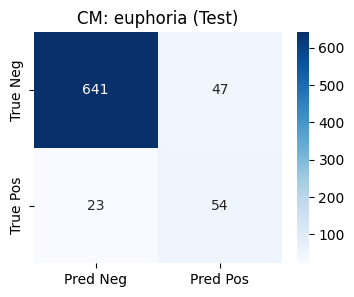


--- Processing: fud ---
Training data: 310 positive samples out of 3057
Applying SMOTE...
After SMOTE: 2747/5494
Initializing LinearSVC model...
Training LinearSVC model...
Training complete.
Evaluating on TEST set...
Test Accuracy: 0.8954
Test F1-Score (Positive Class): 0.4667
Test Classification Report:
              precision    recall  f1-score   support

     Not_fud       0.94      0.94      0.94       690
         fud       0.47      0.47      0.47        75

    accuracy                           0.90       765
   macro avg       0.70      0.70      0.70       765
weighted avg       0.90      0.90      0.90       765

Test Confusion Matrix:
[[650  40]
 [ 40  35]]


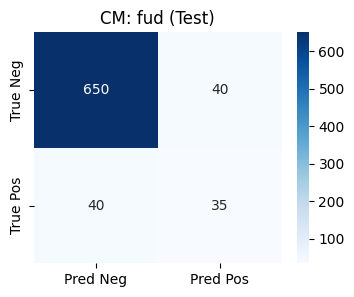


--- Processing: glittering_generalities ---
Training data: 386 positive samples out of 3057
Applying SMOTE...
After SMOTE: 2671/5342
Initializing LinearSVC model...
Training LinearSVC model...
Training complete.
Evaluating on TEST set...
Test Accuracy: 0.8928
Test F1-Score (Positive Class): 0.6058
Test Classification Report:
                             precision    recall  f1-score   support

Not_glittering_generalities       0.95      0.93      0.94       668
    glittering_generalities       0.57      0.65      0.61        97

                   accuracy                           0.89       765
                  macro avg       0.76      0.79      0.77       765
               weighted avg       0.90      0.89      0.90       765

Test Confusion Matrix:
[[620  48]
 [ 34  63]]


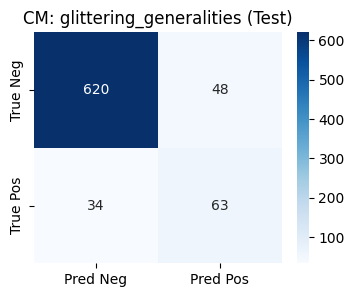


--- Processing: loaded_language ---
Training data: 1581 positive samples out of 3057
Applying SMOTE...
After SMOTE: 1581/3162
Initializing LinearSVC model...
Training LinearSVC model...
Training complete.
Evaluating on TEST set...
Test Accuracy: 0.6967
Test F1-Score (Positive Class): 0.7041
Test Classification Report:
                     precision    recall  f1-score   support

Not_loaded_language       0.69      0.69      0.69       373
    loaded_language       0.70      0.70      0.70       392

           accuracy                           0.70       765
          macro avg       0.70      0.70      0.70       765
       weighted avg       0.70      0.70      0.70       765

Test Confusion Matrix:
[[257 116]
 [116 276]]


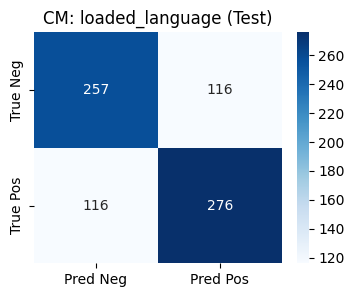


--- Processing: straw_man ---
Training data: 113 positive samples out of 3057
Applying SMOTE...
After SMOTE: 2944/5888
Initializing LinearSVC model...
Training LinearSVC model...
Training complete.
Evaluating on TEST set...
Test Accuracy: 0.9438
Test F1-Score (Positive Class): 0.1887
Test Classification Report:
               precision    recall  f1-score   support

Not_straw_man       0.97      0.97      0.97       740
    straw_man       0.18      0.20      0.19        25

     accuracy                           0.94       765
    macro avg       0.58      0.58      0.58       765
 weighted avg       0.95      0.94      0.95       765

Test Confusion Matrix:
[[717  23]
 [ 20   5]]


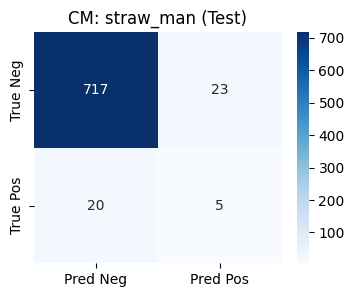


--- Processing: whataboutism ---
Training data: 124 positive samples out of 3057
Applying SMOTE...
After SMOTE: 2933/5866
Initializing LinearSVC model...
Training LinearSVC model...
Training complete.
Evaluating on TEST set...
Test Accuracy: 0.9516
Test F1-Score (Positive Class): 0.3729
Test Classification Report:
                  precision    recall  f1-score   support

Not_whataboutism       0.97      0.98      0.97       731
    whataboutism       0.44      0.32      0.37        34

        accuracy                           0.95       765
       macro avg       0.70      0.65      0.67       765
    weighted avg       0.95      0.95      0.95       765

Test Confusion Matrix:
[[717  14]
 [ 23  11]]


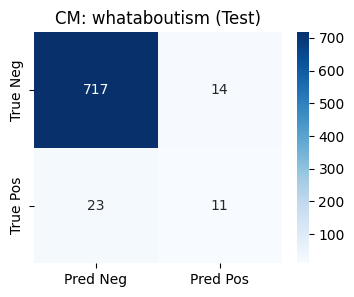


--- Processing Complete for all techniques (using LinearSVC) ---


In [8]:
# %% [code] {"id":"50MEBVX3Plnn_LinearSVC_dual_fix"}
# Import LinearSVC if not done globally
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix # Ensure metrics are imported

# Dictionary to store trained models and evaluation results
models = {}
results = {}

# Loop through each technique column defined in CANONICAL_TECHNIQUES
for technique in technique_columns:
    print(f"\n--- Processing: {technique} ---")

    # Get the specific target labels for this technique for train and test splits
    # Assumes Train/Test split from Cell 4
    y_train_technique = y_train_df[technique]
    y_test_technique = y_test_df[technique]

    # Check class distribution in training data
    positive_class_count_train = y_train_technique.sum()
    total_count_train = len(y_train_technique)
    print(f"Training data: {positive_class_count_train} positive samples out of {total_count_train}")
    if positive_class_count_train < 5: print(f"Warning: Very few positive samples for '{technique}'.")

    # --- Apply SMOTE (remains the same) ---
    X_train_resampled = X_train_tfidf # Assumes X_train_tfidf might include combined features from Cell 5
    y_train_resampled = y_train_technique
    try: # SMOTE Logic
        if positive_class_count_train > 0 and positive_class_count_train < total_count_train:
            print("Applying SMOTE...")
            k_neighbors_smote = min(4, positive_class_count_train - 1) if positive_class_count_train > 1 else 1
            smote = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train_technique)
            print(f"After SMOTE: {y_train_resampled.sum()}/{len(y_train_resampled)}")
        else: print("Skipping SMOTE.")
    except Exception as e_smote: print(f"SMOTE Error for {technique}: {e_smote}. Using original data.")

    # --- Initialize the Classifier: LinearSVC ---
    print("Initializing LinearSVC model...")
    model = LinearSVC(
        class_weight='balanced',
        C=1.0,
        dual=False,         # <<<--- CHANGED 'auto' to False (preferred when n_features > n_samples)
        random_state=42,
        max_iter=2000       # Keep increased iterations
    )

    # Train the model
    print("Training LinearSVC model...")
    model.fit(X_train_resampled, y_train_resampled)
    print("Training complete.")

    # --- Evaluation on TEST set ---
    print(f"Evaluating on TEST set...")
    y_test_pred_final = model.predict(X_test_tfidf) # X_test_tfidf might be combined features

    # --- Calculate Test Metrics (same logic as before) ---
    accuracy = accuracy_score(y_test_technique, y_test_pred_final)
    print(f"Test Accuracy: {accuracy:.4f}")
    test_f1 = 0.0
    report = "N/A - Only one class present in y_test"
    cm = None
    unique_classes_in_test = np.unique(y_test_technique)
    num_unique_classes_test = len(unique_classes_in_test)

    if num_unique_classes_test == 2:
        test_f1 = f1_score(y_test_technique, y_test_pred_final, average='binary', pos_label=1, zero_division=0)
        report = classification_report(y_test_technique, y_test_pred_final, target_names=['Not_' + technique, technique], zero_division=0)
        cm = confusion_matrix(y_test_technique, y_test_pred_final, labels=[0, 1])
        print(f"Test F1-Score (Positive Class): {test_f1:.4f}")
        print("Test Classification Report:")
        print(report)
        print("Test Confusion Matrix:")
        print(cm)
        # Plot Confusion Matrix
        plt.figure(figsize=(4, 3)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['True Neg', 'True Pos']); plt.title(f'CM: {technique} (Test)'); plt.show()
    else: print(f"Warning: Only one class ({unique_classes_in_test}) found in TEST set for '{technique}'.")

    # Store the model and results
    models[technique] = model
    results[technique] = {
        'accuracy': accuracy,
        'f1_score_positive': test_f1 if num_unique_classes_test == 2 else np.nan,
        'report': report, 'confusion_matrix': cm
    }

print("\n--- Processing Complete for all techniques (using LinearSVC) ---")

In [9]:
# %% [code] {"id":"VhZ9l8kySD3W_metrics_LinearSVC"}
# --- Part 1: Summary of Individual Classifier Performance ---
summary_df = pd.DataFrame(results).T
# Remove best_threshold if it's not stored
summary_df = summary_df[['accuracy', 'f1_score_positive']].astype({'f1_score_positive': float, 'accuracy': float})
print("\n--- Individual Classifier Performance Summary (Test Set - LinearSVC) ---") # Updated print
print(summary_df.sort_values(by='f1_score_positive', ascending=False))

# --- Part 2: Calculate Overall Multi-Label Metrics on TEST Set ---
print("\n--- Overall Multi-Label Performance Metrics (Test Set - LinearSVC) ---") # Updated print

# 1. Generate the multi-label prediction matrix for the TEST set using model.predict()
all_test_predictions = {}
for technique, model in models.items():
    if model is not None:
        # Use predict() directly from LinearSVC
        y_pred_single_test = model.predict(X_test_tfidf) # X_test_tfidf might be combined features
        all_test_predictions[technique] = y_pred_single_test
    else:
        print(f"Warning: Model for '{technique}' not found. Predicting zeros.")
        all_test_predictions[technique] = np.zeros(X_test_tfidf.shape[0], dtype=int)

y_pred_multi_df = pd.DataFrame(all_test_predictions, index=y_test_df.index)[technique_columns]
y_true_multi_test = y_test_df.values # Assuming y_test_df exists from Cell 4
y_pred_multi_test = y_pred_multi_df.values

# 2. Calculate Metrics (logic remains the same)
# ... (calculation of macro_f1, micro_f1, etc. - same as before) ...
macro_f1 = f1_score(y_true_multi_test, y_pred_multi_test, average='macro', zero_division=0); print(f"\nOverall Macro-F1 (Test): {macro_f1:.4f}")
micro_f1 = f1_score(y_true_multi_test, y_pred_multi_test, average='micro', zero_division=0); print(f"Overall Micro-F1 (Test): {micro_f1:.4f}")
weighted_f1 = f1_score(y_true_multi_test, y_pred_multi_test, average='weighted', zero_division=0); print(f"Overall Weighted-F1 (Test): {weighted_f1:.4f}")
samples_f1 = f1_score(y_true_multi_test, y_pred_multi_test, average='samples', zero_division=0); print(f"Overall Samples-F1 (Test): {samples_f1:.4f}")
hamming = hamming_loss(y_true_multi_test, y_pred_multi_test); print(f"Hamming Loss (Test): {hamming:.4f}")

# 3. Display the full multi-label classification report (logic remains the same)
print("\nOverall Classification Report (Multi-Label - Test Set - LinearSVC):") # Updated print
print(classification_report(y_true_multi_test, y_pred_multi_test, target_names=technique_columns, zero_division=0))


--- Individual Classifier Performance Summary (Test Set - LinearSVC) ---
                         accuracy  f1_score_positive
loaded_language          0.696732           0.704082
euphoria                 0.908497           0.606742
glittering_generalities  0.892810           0.605769
fud                      0.895425           0.466667
cherry_picking           0.832680           0.433628
whataboutism             0.951634           0.372881
appeal_to_fear           0.879739           0.292308
cliche                   0.788235           0.228571
straw_man                0.943791           0.188679
bandwagon                0.935948           0.140351

--- Overall Multi-Label Performance Metrics (Test Set - LinearSVC) ---

Overall Macro-F1 (Test): 0.4040
Overall Micro-F1 (Test): 0.5255
Overall Weighted-F1 (Test): 0.5280
Overall Samples-F1 (Test): 0.3639
Hamming Loss (Test): 0.1275

Overall Classification Report (Multi-Label - Test Set - LinearSVC):
                         precision    re

In [10]:
# %% [code] {"id":"GQziKOCYT8uT_submission_LinearSVC"}
import re
from scipy.sparse import hstack, csr_matrix
import numpy as np

# --- Prerequisites Check ---
# Removed best_thresholds from check
required_vars = ['models', 'tfidf_vectorizer', 'technique_columns',
                 'X_train_tfidf', 'y_train_df', 'clean_text', 'trigger_patterns',
                 'USE_TRIGGER_PRESENCE_FEATURES', 'CANONICAL_TECHNIQUES',
                 'DATA_PATH_TEST', 'SUBMISSION_PATH']
missing_vars = [var for var in required_vars if var not in locals() and var not in globals()]
if missing_vars: raise NameError(f"Missing required variables: {missing_vars}.")

print("--- Part 1: Evaluate Model Fit on Training Data ---")
# 1. Generate predictions for the TRAINING set using model.predict()
all_train_predictions = {}
print("Generating predictions on the training data (LinearSVC)...") # Updated print
for technique, model in models.items():
    if model is not None:
        y_pred_single_train = model.predict(X_train_tfidf) # Use predict()
        all_train_predictions[technique] = y_pred_single_train
    else:
        print(f"Warning: Model for '{technique}' not found. Predicting zeros.")
        all_train_predictions[technique] = np.zeros(X_train_tfidf.shape[0], dtype=int)
# ... (rest of training evaluation calculation and printing - same as before) ...
y_pred_train_multi_df = pd.DataFrame(all_train_predictions, index=y_train_df.index)[technique_columns]
y_true_train_multi = y_train_df.values; y_pred_train_multi = y_pred_train_multi_df.values
print("\nCalculating multi-label metrics on TRAINING data...")
train_macro_f1=f1_score(y_true_train_multi,y_pred_train_multi,average='macro',zero_division=0);print(f"Train Macro-F1:{train_macro_f1:.4f}")
# ... (print other training metrics) ...
print("\nTraining Set Classification Report (Multi-Label):")
print(classification_report(y_true_train_multi, y_pred_train_multi, target_names=technique_columns, zero_division=0))
print("-" * 50)

print("\n--- Part 2: Load and Predict on Official Test Data (test.csv) ---")
# 1. Load Official Test Data
# ... (loading logic) ...
try: df_official_test = pd.read_csv(DATA_PATH_TEST)
except FileNotFoundError: raise SystemExit("Stopping - Official Test file required.")
except Exception as e: raise SystemExit(f"Stopping - Failed to load official test file: {e}")
if 'id' not in df_official_test.columns: raise ValueError("'id' not found.")
if 'content' not in df_official_test.columns: raise ValueError("'content' not found.")
print(f"Loaded {DATA_PATH_TEST}. Shape: {df_official_test.shape}")

# 2. Preprocess Official Test Data Text
# ... (preprocessing logic) ...
print("\nPreprocessing official test text...")
df_official_test['content'] = df_official_test['content'].fillna('')
df_official_test['cleaned_content'] = df_official_test['content'].apply(clean_text)
print("Preprocessing complete.")

# 3. Transform Official Test Data using Fitted TF-IDF Vectorizer
# ... (TF-IDF transform logic) ...
print("\nApplying TF-IDF transformation...")
try: X_official_test_tfidf = tfidf_vectorizer.transform(df_official_test['cleaned_content'])
except Exception as e: raise RuntimeError(f"Error during TF-IDF transformation: {e}")
print(f"TF-IDF transformation complete. Shape: {X_official_test_tfidf.shape}")

# --- Apply Trigger Presence Features to Official Test Data (if used in training) ---
# (Logic remains the same as previous version)
if USE_TRIGGER_PRESENCE_FEATURES:
    print("\nApplying trigger presence features to official test data...")
    def check_trigger_presence_regex(text, pattern):
        if pattern and isinstance(text, str): return 1 if pattern.search(text) else 0
        return 0
    trigger_features_official_test = []
    for tech in CANONICAL_TECHNIQUES:
        pattern = trigger_patterns.get(tech)
        if pattern: trigger_features_official_test.append(df_official_test['cleaned_content'].apply(lambda text: check_trigger_presence_regex(text, pattern)))
    if trigger_features_official_test:
        trigger_array_official_test = np.array(trigger_features_official_test).T
        trigger_sparse_official_test = csr_matrix(trigger_array_official_test)
        print("Combining TF-IDF with trigger features...")
        X_official_test_tfidf = hstack([X_official_test_tfidf, trigger_sparse_official_test], format='csr')
        print(f"Shape AFTER combining: {X_official_test_tfidf.shape}")
    else: print("Warning: USE_TRIGGER_PRESENCE_FEATURES True, but no trigger features generated.")

# 4. Predict on Transformed Official Test Data using model.predict()
print("\nGenerating predictions for official test data (LinearSVC)...") # Updated print
official_test_predictions = {}
for technique, model in models.items():
    if model is not None:
        # Use predict() directly from LinearSVC
        y_pred_official_test_single = model.predict(X_official_test_tfidf) # X_official_test_tfidf might be combined
        official_test_predictions[technique] = y_pred_official_test_single
    else:
        print(f"Warning: Model for '{technique}' not found. Predicting zeros.")
        official_test_predictions[technique] = np.zeros(X_official_test_tfidf.shape[0], dtype=int)

df_official_test_predictions = pd.DataFrame(official_test_predictions)[technique_columns]
print("Predictions generated.")

print("\n--- Part 3: Create Submission File ---")
# (This part remains the same)
# ... (Combine IDs and predictions) ...
# ... (Verify column order) ...
# ... (Save to CSV) ...
df_submission = pd.concat([df_official_test[['id']], df_official_test_predictions], axis=1)
expected_columns = ['id'] + list(technique_columns);
if list(df_submission.columns)!=expected_columns: print("Warning: Reordering columns."); df_submission=df_submission[expected_columns]
print(f"\nSubmission DataFrame preview:"); print(df_submission.head())
try: df_submission.to_csv(SUBMISSION_PATH, index=False); print(f"\nSubmission file created: {SUBMISSION_PATH}")
except Exception as e: print(f"\nError saving submission file: {e}")

print("\n--- Cell 8 Execution Complete ---")

--- Part 1: Evaluate Model Fit on Training Data ---
Generating predictions on the training data (LinearSVC)...

Calculating multi-label metrics on TRAINING data...
Train Macro-F1:0.9687

Training Set Classification Report (Multi-Label):
                         precision    recall  f1-score   support

         appeal_to_fear       0.95      1.00      0.97       242
              bandwagon       0.97      1.00      0.98       122
         cherry_picking       0.88      1.00      0.93       415
                 cliche       0.91      0.99      0.95       370
               euphoria       0.94      1.00      0.97       385
                    fud       0.94      1.00      0.97       310
glittering_generalities       0.95      1.00      0.97       386
        loaded_language       0.95      0.96      0.96      1581
              straw_man       0.98      1.00      0.99       113
           whataboutism       0.98      1.00      0.99       124

              micro avg       0.94      0.98  